# Welcome to Lung Cancer Center of Excellence Workshop 2023!

**This is data description and code snippets made for Python users, if you prefer R, please click [here]()**

## General information <a class="anchor" id="General-information"></a>
The workshop is based on data generated by the TRACERx (Tracking Cancer Evolution through Therapy (Rx) project. It is a large-scale research project aimed at understanding how cancer evolves and spreads over time. The project involves collecting multiple samples of tumours and analysing them in detail to identify genetic changes that occur as the cancer progresses.

Overall, **1,644 tumour regions** were sampled at surgery or during follow-up from the first **421 patients** with non-small cell lung cancer (NSCLC). The samples were subjected to whole exome sequencing (WES) and RNA-seq and thoroughly analysed. In total, **432 genomically distinct tumours** were found. The results obtained from this analysis serve as the foundation for generating hypotheses during this workshop.

The available data include:
1. patient pathology and clinical data
2. somatic mutations
3. somatic copy number alterations
4. expression data

While rudimentary plots summarising the data are available below, we highly encourage you to have a brief look through the [collection of TRACERx papers](https://www.nature.com/collections/haffgaicaf). In particular, somatic point and copy number alterations are discussed [here](https://www.nature.com/articles/s41586-023-05783-5) and expression changes are examined [here](https://www.nature.com/articles/s41586-023-05706-4).

--------------------------------------------------------------------------------
## How to download the data <a class="anchor" id="How-to_download-the-data"></a>

[Scroll up](#TOC)

Please head to [zenodo](https://zenodo.org/record/7822002) and press download:

![zenodo](https://github.com/McGranahanLab/LCCE_workshop_2023/blob/master/support_illustrations/zenodo.png)

The archive `figurecode.zip` will be downloaded, please unzip it. It will produce the folder `figurecode`. While the folder contains a multitude of files, we believe a handful of them can go a long way in terms of hypothesis generation:

* 20221109_TRACERx421_all_tumour_df.rds
* [Somatic single point mutations and small indels](#Somatic-mutation-data): 20221123_TRACERx421_mutation_table_region.fst
* Somatic copy number alterations: 20221109_TRACERx421_scna_table.fst

> Coordinates of mutations and CNAs in all listed files are in hg19.

--------------------------------------------------------------------------------
## Required software and packages <a class="anchor" id="Required-software-and-packages"></a>
[Scroll up](#TOC)


In order to load the data into Python, perform minimal data wrangling and visualization, we reccomend using `pandas`, `pyreadr`, `fst` and `matplotlib` packages freely avaible from [`pip`](https://pypi.org/project/pip/) or [`conda`](https://docs.conda.io/en/latest/). But please do feel free to use any packages you are used to or find helpful!

In [45]:
import collections
import pandas as pd
import pyreadr
import fst
import matplotlib.pyplot as plt

--------------------------------------------------------------------------------

## I am not able to install required software/packages on my computer, what should I do? <a class="anchor" id="I-am-not-able-to-install"></a>

[Scroll up](#TOC)

Insert here how to use google colab

--------------------------------------------------------------------------------
## Clinical data <a class="anchor" id="Clinical"></a>

[Scroll up](#TOC) 

### Reading data into Python <a class="anchor" id="Clinical-Reading"></a>
TRACERx cohort consists of 421 patients. Each line in this dataframe corresponds to one of these patients, reporting clinical data.

In [41]:
clinical_df = pyreadr.read_r('figurecode/data/20221109_TRACERx421_all_patient_df.Rds')
clinical_df = pd.DataFrame(clinical_df[None])
# rename columns to match ones in mutation table and cna.
# Please do not skip this step
clinical_df.rename(columns = {'cruk_id' : 'patient_id'})
# remove excess columns, please do not skip this step
clinical_df.drop(columns = ['tumour_id_muttable_cruk', 'tumour_id_per_patient'],
                 inplace = True)

### Column description <a class="anchor" id="Clinical-Columns"></a>

In [43]:
clinical_df.head()

,cruk_id,age,sex,ethnicity,cigs_perday,years_smoking,packyears,smoking_status_merged,is.family.lung,ECOG_PS,...,os_time,cens_dfs,dfs_time,cens_dfs_any_event,dfs_time_any_event,cens_lung_event,lung_event_time,Relapse_cat,Relapse_cat_new,tx100
0,CRUK0034,68,Female,White- Irish,20.0,35,35.000,Ex-Smoker,True,0.0,...,1849,0,1849,0,1849,0,1849,NaN,No rec,True
1,CRUK0150,81,Male,White- British,44.5,49,109.025,Ex-Smoker,False,0.0,...,1362,1,1362,1,1362,0,1362,NaN,No rec,False
2,CRUK0159,60,Male,White- British,20.0,38,38.000,Smoker,False,0.0,...,2224,1,2224,1,1935,0,2224,Second primary lung,No rec,False
3,CRUK0090,65,Male,White- British,10.0,35,17.500,Ex-Smoker,False,1.0,...,2365,1,1143,1,1143,1,1143,Intrathoracic,Intrathoracic,True
4,CRUK0045,85,Male,White- British,10.0,25,12.500,Ex-Smoker,False,1.0,...,986,1,917,1,917,1,917,Intrathoracic,Intrathoracic,True


* `patient_id` : unique patient identifier
* `age` : age of the patient
* `sex` : sex of the patient
* `ethnicity` : ethnicity of the patient
* `cigs_perday` : number of cigarettes smoked per day. There are non integer values because some patients smoke cigars or pipes, whose amount was converted to the equivalent in cigarette counts. One cigar is assumed to be equivalent to approximately 1.5 cigarettes, and for pipes, one bowl of tobacco is equivalent to 2.5 cigarettes, following the table presented [here](https://gpnotebook.com/simplepage.cfm?ID=x20070115071949295600) for conversions.
* `years_smoking` : number of years the patient has been smoking.
* `packyears` :  number of cigarette packs smoked per year.
* `smoking_status_merged` : smoking status of the patient. Can be one of `Ex-Smoker`,`Smoker`, `Never Smoked`.
* `is.family.lung` : logical indicating whether there is a history of lung cancer in the family.
* `ECOG_PS` : (?)
* `pathologyTNM` : (?)
* `pT_stage_per_lesion` : tumor stage, please see [CRUK TNM staging page](https://www.cancerresearchuk.org/about-cancer/lung-cancer/stages-types-grades/tnm-staging) for the detailed description
* `pN_stage_per_lesion` : lymph node stage, please see [CRUK TNM staging page](https://www.cancerresearchuk.org/about-cancer/lung-cancer/stages-types-grades/tnm-staging) for the detailed description
* `LVI_per_patient` : if patient had lymphovascular invasion (LVI)
* `PL_per_patient` : (?)
* `margin_status_per_patient` : (?)
* `size_pathology_per_patient` : size of the tumor, in mm
* `Surgery_type` : surgery performed on patient. Can be one of `Lobectomy`,`Segmentectomy`, `wedge resection`, `Bilobectomy`, `Pneumonectomy`, `Lobectomy and wedge resection`, `Lingulectomy`.
* `histology_lesion1` : histological subtype of the first lesion, one of `Invasive adenocarcinoma`, `LCNEC`, `Squamous cell carcinoma`,`Pleomorphic carcinoma`, `Adenosquamous carcinoma`, `Carcinosarcoma`, `combined LUAD and LCNEC`, `Large cell carcinoma`, `Collision LUAD and LUSC`.
* `histology_lesion1_merged` : (?)
* `lesion1_sampled` : logical indicator whether first lesion was sampled
* `histology_lesion2` : histological subtype of the second lesion, one of `Minimally invasive adenocarcinoma`, `Lesion1: collision tumour`, `Invasive adenocarcinoma`, `Unknown`, `Squamous cell carcinoma`, `Carcinoid` (when sampled)
* `lesion2_sampled` : logical indicator whether second lesion was sampled
* `histology_multi_full` : (?)
* `histology_multi_full_genomically.confirmed` : (?)
* `LUAD_pred_subtype` :  for LUAD samples, this column contains the tissue architecture growth pattern. Such patterns are inferred from diagnostic H&E slides, and they can be divided in two categories: low-grade (lepidic, mid grade, papillary and acinar) and high-grade (cribriform, micropapillary and solid).
* `adjuvant_treatment_YN` : can either be `No adjuvant` or `Adjuvant` based on whether the patient received adjuvant treatment
* `adjuvant_treatment_given` : which adjuvant treatment was given to the patient. It can be one of `Platinum chemo`, `Radiotherapy` and `Platinum chemo/radiotherapy`. For patients who did not receive adjuvant treatment, this column is NA.
* `num_cycle_na.added` : number of cycles of adjuvant treatment given to the patient. For those who did not receive AT, this column is equal to 0.
* `CHMPlatDgName_cleaned` : name of the chemotherapy platinum agent used in each AT cycle. The drug names for each cycle are separated by ';', e.g., `Cisplatin;Carboplatin`.
* `CHMOthDgName_cleaned` : name of the second chemotherapy drug given in combination with the platinum agent. Drug names in each cycle are separated by ';'.
* `AdjRadStartTime_manual` : time when adjuvant radiotherapy started (when applicable)
* `AdjRadEndTime_manual` : end time point of the adjuvant radiotherapy (when applicable)
* `Recurrence_time_use` : time when recurrence was confirmed
* `newPrim_time_use` : time when a new primary tumour was detected.
* `first_dfs_any_event_rec.or.new.primary` : whether this patient underwent a recurrence event or developed a new primary tumour. There are 41 new primaries, and 5 of them developed a recurrence.
* `first_event_during_followup` : one of `Death`, `new_primary`, `recurrence` and `recurrence (death)`.
* `cens_os` : indicates, if patient was censored for computations of overall survival (OS)
* `os_time` : overall survival time
* `cens_dfs` : indicates, if patient was censored due to death
* `dfs_time` : death time
* `cens_dfs_any_event` : (?)
* `dfs_time_any_event` : (?)
* `cens_lung_event` : (?)
* `lung_event_time` : (?)
* `Relapse_cat` : physical location of relapse tumor, one of `Second primary lung`, `Intrathoracic`, `Intra & Extra`, `Other second primary`, `Extrathoracic`, `Missing data`
* `Relapse_cat_new` : updated physical location of relapse tumor, one of `No rec`, `Intrathoracic`, `Intra & Extra`, `Extrathoracic`, `Unknown Site`
* `tx100` : logical indicator of patient's participation in TRACERx 100 cohort

###  Overview plots  <a class="anchor" id="Clinical-plots"></a>
Let's have a look at patients' distribution across age, sex, ethnicity, number of cigarettes per day and overall pack years

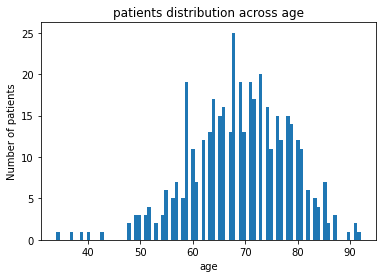

In [50]:
plt.hist(clinical_df['age'], bins = 90)
plt.ylabel('Number of patients')
plt.xlabel('age')
plt.title('patients distribution across age')
plt.show() 

--------------------------------------------------------------------------------
## Pathology data <a class="anchor" id="pathology"></a>
[Scroll up](#TOC)

TRACERx cohort consists of 421 patients, harbouring 432 genomically independent tumours. Each line in this data frame corresponds to one of these tumours, reporting clinical data and histological features.

### Reading data into R <a class="anchor" id="Pathology-Reading"></a>

In [57]:
tumor_df = pyreadr.read_r('figurecode/data/20221109_TRACERx421_all_tumour_df.rds')
tumor_df = pd.DataFrame(tumor_df[None])
# rename columns to match ones in mutation table and cna
# please do not skip this step
tumor_df.rename(columns = {'tumour_id_muttable_cruk' : 'tumour_id',
                           'cruk_id' : 'patient_id'}, inplace = True)

### Column description <a class="anchor" id="Pathology-Columns"></a>

In [58]:
tumor_df.head()

,tumour_id,patient_id,clinical_sex,age,ethnicity,Histology_per_tumour_id_muttable,histology_3,LUAD_pred_subtype_with.IMA_per_tumour,site_per_lesion,pT_stage_per_lesion,pN_stage_per_lesion,size_pathology_per_lesion,vascular_invasion_per_lesion,pleural_invasion_per_lesion,smoking_status_merged,cigs_perday,years_smoking,pack_years,is.family.lung,pathologyTNM
0,CRUK0034,CRUK0034,Female,68,White- Irish,Invasive adenocarcinoma,LUAD,acinar,Right Upper Lobe,2a,0,40,Yes,No,Ex-Smoker,20.0,35,35.000,True,IB
1,CRUK0150,CRUK0150,Male,81,White- British,LCNEC,Other,NaN,Left Upper Lobe,3,0,75,Yes,No,Ex-Smoker,44.5,49,109.025,False,IIB
2,CRUK0159,CRUK0159,Male,60,White- British,Invasive adenocarcinoma,LUAD,acinar,Right Upper Lobe,2a,0,36,Yes,Yes,Smoker,20.0,38,38.000,False,IB
3,CRUK0090,CRUK0090,Male,65,White- British,Squamous cell carcinoma,LUSC,NaN,Right Upper Lobe,2a,1,35,Yes,Yes,Ex-Smoker,10.0,35,17.500,False,IIA
4,CRUK0045,CRUK0045,Male,85,White- British,Invasive adenocarcinoma,LUAD,papillary,Left Lower Lobe,2a,0,48,Yes,Yes,Ex-Smoker,10.0,25,12.500,False,IB


The columns in the dataframe are the following:
* `patient_id` : unique patient identifier
* `tumour_id` : unique tumor identifier
* `clinical_sex`: patient sex
* `age` : patient age
* `ethnicity` : patient ethnicity. It is one of: `White- Irish`, `White- British`, `Caribbean`, `Black`, `White and Asian`, `White-European`, `White- Other`, `South American`, `Indian`, `Middle eastern`, `White and Black`)
* `Histology_per_tumour_id_muttable` : full name of the tumor sample histological subtype. It's one of: `Invasive adenocarcinoma`, `LCNEC`, `Squamous cell carcinoma`, `Pleomorphic Adenosquamous carcinoma`, `Carcinosarcoma`, `combined LUAD and LCNEC`, `Large cell carcinoma`, `Collision LUAD and LUSC`.
* `histology_3` : for samples that are either `Invasive adenocarcinoma` or `Squamous cell carcinoma` this column is equal to LUAD and LUSC respectively. For all other histologies, this column contains `Other`.
* `LUAD_pred_subtype_with.IMA_per_tumour` : For LUAD samples, this column contains the tissue architecture growth pattern. Such patterns are inferred from diagnostic H&E slides, and they can be divided in two categories: low-grade (lepidic, mid grade, papillary and acinar) and high-grade (cribriform, micropapillary and solid).
* `site_per_lesion` : location of the tumor. It is one of `Right Upper Lobe`, `Left Upper Lobe`, `Left Lower Lobe`, `Right Lower Lobe`, `Right Middle Lobe`, `Left Upper lobe`
* `pT_stage_per_lesion` : tumor stage, please see [CRUK TNM staging page](https://www.cancerresearchuk.org/about-cancer/lung-cancer/stages-types-grades/tnm-staging) for the detailed description
* `pN_stage_per_lesion` : lymph node stage, please see [CRUK TNM staging page](https://www.cancerresearchuk.org/about-cancer/lung-cancer/stages-types-grades/tnm-staging) for the detailed description
* `size_pathology_per_lesion` : pathological tumor size. (?) how is it calculated? It ranges between 7 and 140
* `vascular_invasion_per_lesion` : logical indicating the presence of lymphovascular invasion.
* `pleural_invasion_per_lesion` : logical indicating the presence of visceral pleural invasion.
* `smoking_status_merged` : smoking status of the patient. Can be `Ex-Smoker`, `Smoker` and `Never Smoked`
* `cigs_perday` : number of cigarettes smoked per day. There are non integer values because some patients smoke cigars or pipes, whose amount was converted to the equivalent in cigarette counts. One cigar is assumed to be equivalent to approximately 1.5 cigarettes, and for pipes, one bowl of tobacco is equivalent to 2.5 cigarettes, following the table presented [here](http://www.smoking2.nes.scot.nhs.uk/module4/working-out-cigarette-equivalents.html) for conversions.
* `years_smoking` : duration for smoking in terms of years.
* `pack_years` : number of cigarette packs smoked per year.
* `is.family.lung` : (?) I don't know what this stands for. Probably is logical indicating whether there is a history of lung cancer in the family.
* `pathologyTNM` : pathological Tumor, Node and Metastasis (TNM) stage (? check I defined it right)

###  Overview plots  <a class="anchor" id="Pathology-plots"></a>
Let's have a look at patients' distribution across tumor subtypes